# Interconnection Queues Analysis

How likely is each project in the queue to be completed?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import datetime

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [113]:
model_df = pd.read_parquet('CAISO_qs.parquet')

## LogReg Attempt 1

In [114]:
#Split the active projects from the completed/withdraawn projects to first analyze the completed/withdrawn projects

active = model_df[model_df["Status"] == "ACTIVE"]
inactive = model_df[model_df["Status"] != "ACTIVE"]

#Create X and y for model
X = inactive.drop(columns="Status").astype('float64')
y = pd.get_dummies(inactive["Status"]).drop(columns='WITHDRAWN').rename(columns={'COMPLETED':'Status'}).astype('float64')

In [115]:
#Split data for models

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

In [116]:
#Normalize data because we incorporate categorical and numerical variables, all measured differently
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Create and fit logistic regression model
model = LogisticRegression(penalty='l2')
model.fit(X_train, y_train.values.ravel())

#Make predictions on test set
predictions = model.predict(X_test)

#Evaluate model performance
accuracy = model.score(X_test, y_test)

In [117]:
accuracy

0.8969359331476323

In [118]:
#To get p values:

# add a column of ones for the intercept in X_test
X_test = sm.add_constant(X_test) #but now we're saying this doesn't work

# predict the probabilities of y_test using X_test and logreg
y_pred = model.predict_proba(X_test)[:,1]

In [120]:
# get the coefficients and intercept

coef = model.coef_
intercept = model.intercept_
intercept

array([-2.80243112])

In [121]:
# create a dataframe of the feature names and coefficients. 
#There's a lot of features for this to be interpretable

feature_names = list(inactive.drop(columns='Status',axis=1).columns)
coef_df = pd.DataFrame({"feature": feature_names, "coefficient": coef[0]})
coef_df                   

,feature,coefficient
0,Capacity (MW),-1.118709
1,Project Length,0.778763
2,cogeneration,0.181677
3,combustion,-0.007533
4,thermal,0.072119
5,reciprocating,-0.057147
6,storage,-0.982870
7,photovoltaic,-0.122386
8,hydro,-0.303968
9,wind,-0.174802


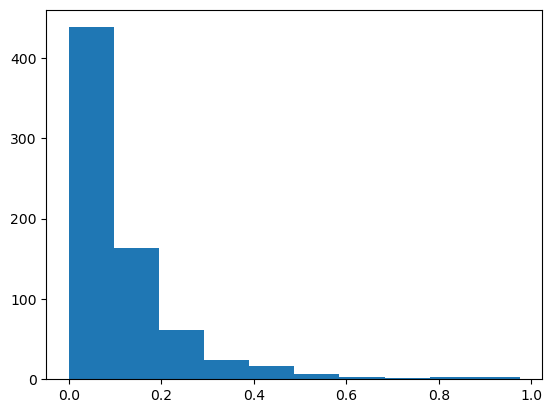

In [123]:
#These are the projects that have over 50% probability of being completed according to the model. 
#Let's join this with the original df.

y_pred = pd.DataFrame(y_pred)
#y_pred[y_pred[0] > .3]
plt.hist(y_pred,bins=10)
plt.show()

In [124]:
# calculate the p-values using statsmodels
logit_model = sm.Logit(y_test,X_test).fit()

#result=logit_model.fit()
logit_model.summary()

#This model won't fit which means there might be too many parameters. This is likely since there are 44.

         Current function value: inf
         Iterations: 35


/Users/larsenburack/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/larsenburack/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


LinAlgError: Singular matrix

## Condensing the parameters

In [125]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2258 entries, 4253 to 6530
Data columns (total 45 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Capacity (MW)   2258 non-null   float64
 1   Status          2258 non-null   object 
 2   Project Length  2258 non-null   int64  
 3   cogeneration    2258 non-null   bool   
 4   combustion      2258 non-null   bool   
 5   thermal         2258 non-null   bool   
 6   reciprocating   2258 non-null   bool   
 7   storage         2258 non-null   bool   
 8   photovoltaic    2258 non-null   bool   
 9   hydro           2258 non-null   bool   
 10  wind            2258 non-null   bool   
 11  gas             2258 non-null   bool   
 12  cycle           2258 non-null   bool   
 13  steam           2258 non-null   bool   
 14  Line            2258 non-null   bool   
 15  Bus             2258 non-null   bool   
 16  Substation      2258 non-null   bool   
 17  TO_DCRT         2258 non-null 

In [126]:
cols = model_df.columns
cols
# for c in cols:
#     if '_' in c:
#         cols.remove(c)
# cols

Index(['Capacity (MW)', 'Status', 'Project Length', 'cogeneration',
       'combustion', 'thermal', 'reciprocating', 'storage', 'photovoltaic',
       'hydro', 'wind', 'gas', 'cycle', 'steam', 'Line', 'Bus', 'Substation',
       'TO_DCRT', 'TO_DSLK', 'TO_GLW', 'TO_IID', 'TO_PGAE', 'TO_SCE',
       'TO_SDGE', 'TO_VEA', 'kv_115', 'kv_12', 'kv_127', 'kv_138', 'kv_160',
       'kv_161', 'kv_170', 'kv_220', 'kv_230', 'kv_260', 'kv_270', 'kv_345',
       'kv_360', 'kv_500', 'kv_55', 'kv_60', 'kv_66', 'kv_69', 'kv_70',
       'kv_8'],
      dtype='object')

In [127]:
for c in list(model_df.columns):
    if '_' in c:
        #print(c)
        model_df = model_df.drop(columns=c)

In [128]:
#Consolidated dataframe

model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2258 entries, 4253 to 6530
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Capacity (MW)   2258 non-null   float64
 1   Status          2258 non-null   object 
 2   Project Length  2258 non-null   int64  
 3   cogeneration    2258 non-null   bool   
 4   combustion      2258 non-null   bool   
 5   thermal         2258 non-null   bool   
 6   reciprocating   2258 non-null   bool   
 7   storage         2258 non-null   bool   
 8   photovoltaic    2258 non-null   bool   
 9   hydro           2258 non-null   bool   
 10  wind            2258 non-null   bool   
 11  gas             2258 non-null   bool   
 12  cycle           2258 non-null   bool   
 13  steam           2258 non-null   bool   
 14  Line            2258 non-null   bool   
 15  Bus             2258 non-null   bool   
 16  Substation      2258 non-null   bool   
dtypes: bool(14), float64(1), int64

## LogReg Attempt 2

In [129]:
#Split the active projects from the completed/withdraawn projects to first analyze the completed/withdrawn projects

active2 = model_df[model_df["Status"] == "ACTIVE"]
inactive2 = model_df[model_df["Status"] != "ACTIVE"]

#Create X and y for model
X = inactive2.drop(columns="Status").astype('float64')
y = pd.get_dummies(inactive2["Status"]).drop(columns='WITHDRAWN').rename(columns={'COMPLETED':'Status'}).astype('float64')
#Split data for models

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

In [130]:
#Normalize data because we incorporate categorical and numerical variables, all measured differently
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Create and fit logistic regression model
model = LogisticRegression(penalty='l2')
model.fit(X_train, y_train.values.ravel())

#Make predictions on test set
predictions = model.predict(X_test)

#Evaluate model performance
accuracy = model.score(X_test, y_test)

In [131]:
accuracy

0.9025069637883009

In [132]:
#To get p values:

# add a column of ones for the intercept in X_test
X_test = sm.add_constant(X_test) #but now we're saying this doesn't work

# predict the probabilities of y_test using X_test and logreg
y_pred = model.predict_proba(X_test)[:,1]

In [133]:
coef = model.coef_
intercept = model.intercept_
intercept

array([-2.67012835])

In [134]:
#Not very good

model.score(X,y)

/Users/larsenburack/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


0.11594202898550725

In [135]:
#for this to be interpretable
# create a dataframe of the feature names and coefficients. 

feature_names = list(inactive2.drop(columns='Status',axis=1).columns)
coef_df = pd.DataFrame({"feature": feature_names, "coefficient": coef[0]})
coef_df.sort_values('coefficient', ascending=False)

,feature,coefficient
1,Project Length,0.747385
2,cogeneration,0.201323
11,cycle,0.162938
10,gas,0.111460
4,thermal,0.074605
3,combustion,0.018441
5,reciprocating,-0.043177
15,Substation,-0.093833
14,Bus,-0.095373
12,steam,-0.118072


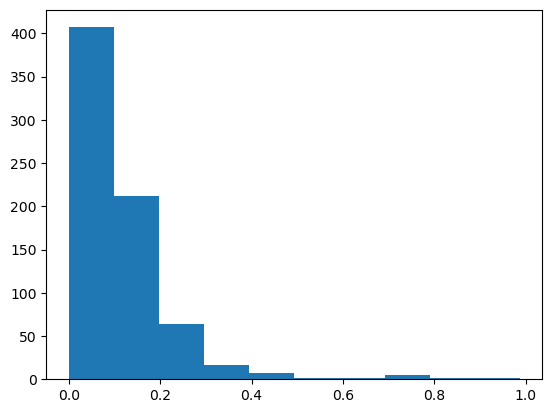

In [136]:
#These are the projects that have over 50% probability of being completed according to the model. 
#Let's join this with the original df.

y_pred = pd.DataFrame(y_pred)
#y_pred[y_pred[0] > .3]
plt.hist(y_pred,bins=10)
plt.show()

In [137]:
# calculate the p-values using statsmodels
logit_model = sm.Logit(y_test,X_test).fit()

#result=logit_model.fit()
logit_model.summary()

         Current function value: 0.263440
         Iterations: 35


/Users/larsenburack/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Status   No. Observations:                  718
Model:                          Logit   Df Residuals:                      702
Method:                           MLE   Df Model:                           15
Date:                Sun, 16 Apr 2023   Pseudo R-squ.:                  0.1506
Time:                        13:21:16   Log-Likelihood:                -189.15
converged:                      False   LL-Null:                       -222.68
Covariance Type:            nonrobust   LLR p-value:                 1.483e-08
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.1745      0.296     -3.970      0.000      -1.754      -0.595
x2             0.8104      0.143      5.668      0.000       0.530       1.091
x3            -0.7706    2.8e+04  -2.75e-05      1.000   -5.49e+04    5.49e+04
x4             0.0807      0.170      0.475      0.635      -0.252       0.413
x5            45.8225   1.47e+04      0.003      0.998   -2.88e+04    2.89e+04
x6            -1.7052   3400.545     -0.001      1.000   -6666.650    6663.240
x7            -0.3806      0.249     -1.526      0.127      -0.870       0.108
x8            -0.0300      0.321     -0.093      0.926      -0.660       0.600
x9             0.3316      0.195      1.704      0.088      -0.050       0.713
x10           -0.0895      0.234     -0.382      0.702      -0.549       0.370
x11           -0.1552      0.235     -0.660      0.509      -0.616       0.306
x12            0.0926      0.231      0.401      0.689      -0.360       0.545
x13           -0.1344      0.239     -0.563      0.573      -0.602       0.333
x14            0.0720      0.160      0.450      0.653      -0.242       0.386
x15            0.0366      0.141      0.260      0.795      -0.240       0.313
x16           -0.0940      0.167     -0.562      0.574      -0.422       0.234
==============================================================================
"""

Only 2 vectors are significant at p < .05 but the p-val of the overall model is good. R2 is very low. Now we'll significantly reduce the parameters in the model and try again.

## LogReg Attempt 3

In [105]:
model_small = model_df[["Project Length","Capacity (MW)","storage","Status"]]

In [106]:
#Split the active projects from the completed/withdraawn projects to first analyze the completed/withdrawn projects

active3 = model_small[model_small["Status"] == "ACTIVE"]
inactive3 = model_small[model_small["Status"] != "ACTIVE"]

In [107]:
#Create X and y for model
X = inactive3.drop(columns="Status").astype('float64')
y = pd.get_dummies(inactive3["Status"]).drop(columns='WITHDRAWN').rename(columns={'COMPLETED':'Status'}).astype('float64')

#Split data for models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

In [108]:
#Normalize data because we incorporate categorical and numerical variables, all measured differently
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Create and fit logistic regression model
model = LogisticRegression() #penalty='l2'
model.fit(X_train, y_train.values.ravel())

#Make predictions on test set
predictions = model.predict(X_test)

#Evaluate model performance
accuracy = model.score(X_test, y_test)
accuracy

0.8997214484679665

In [109]:
#To get p values:

# add a column of ones for the intercept in X_test
X_test = sm.add_constant(X_test) #but now we're saying this doesn't work

# predict the probabilities of y_test using X_test and logreg
#y_pred = model.predict_proba(X_test)[:,1]

coef = model.coef_
intercept = model.intercept_

In [110]:
#Not very good

model.score(X,y)

/Users/larsenburack/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


0.11148272017837235

In [92]:
#for this to be interpretable
# create a dataframe of the feature names and coefficients. 

feature_names = list(inactive3.drop(columns='Status',axis=1).columns)
coef_df = pd.DataFrame({"feature": feature_names, "coefficient": coef[0]})
coef_df.sort_values('coefficient', ascending=False)

/Users/larsenburack/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


,feature,coefficient
0,Project Length,0.706399
1,Capacity (MW),-0.810509
2,storage,-0.946539


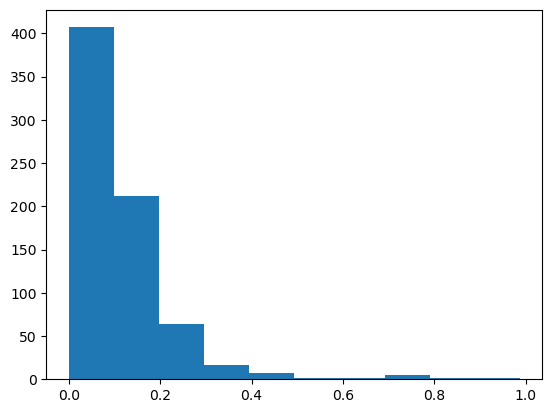

In [103]:
#These are the projects that have over 50% probability of being completed according to the model. 
#Let's join this with the original df.

predictions_df = pd.DataFrame(y_pred)
#y_pred[y_pred[0] > .3]
plt.hist(predictions_df,bins=10)
plt.show()

In [104]:
# calculate the p-values using statsmodels
logit_model = sm.Logit(y_test,X_test).fit()

#result=logit_model.fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.269949
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Status   No. Observations:                  718
Model:                          Logit   Df Residuals:                      714
Method:                           MLE   Df Model:                            3
Date:                Sun, 16 Apr 2023   Pseudo R-squ.:                  0.1296
Time:                        13:04:42   Log-Likelihood:                -193.82
converged:                       True   LL-Null:                       -222.68
Covariance Type:            nonrobust   LLR p-value:                 1.809e-12
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6478      0.178    -14.866      0.000      -2.997      -2.299
x1             0.7788      0.134      5.805      0.000       0.516       1.042
x2            -1.1445      0.292     -3.919      0.000      -1.717      -0.572
x3            -0.3925      0.171     -2.292      0.022      -0.728      -0.057
==============================================================================
"""

Only project length and capacity are statistically significant at p < .05 and the p value of the model as a whole is awful (1). If we add a constant to test data set, all predictors are significant and result is significant. However, the R2 with 3 parameters is worse (.12) than with 16 (.15).

In [139]:
probabilities = logit_model.predict(X_test)

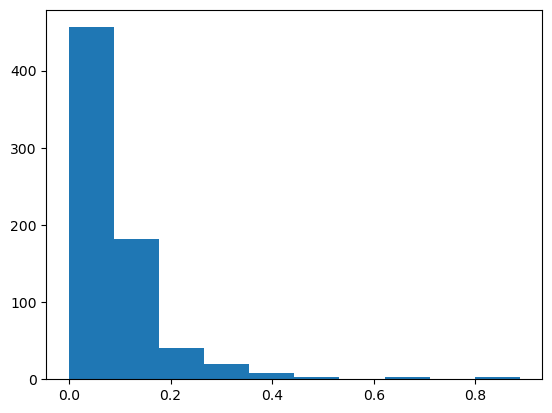

In [143]:
plt.hist(probabilities,bins=10)
plt.show()

## LogReg Attempt 4

In [157]:
model_df['renewable'] = (model_df["thermal"]==1) | (model_df["wind"]==1) | (model_df["photovoltaic"]==1) | (model_df["hydro"]==1)

In [158]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2258 entries, 4253 to 6530
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Capacity (MW)   2258 non-null   float64
 1   Status          2258 non-null   object 
 2   Project Length  2258 non-null   int64  
 3   cogeneration    2258 non-null   bool   
 4   combustion      2258 non-null   bool   
 5   thermal         2258 non-null   bool   
 6   reciprocating   2258 non-null   bool   
 7   storage         2258 non-null   bool   
 8   photovoltaic    2258 non-null   bool   
 9   hydro           2258 non-null   bool   
 10  wind            2258 non-null   bool   
 11  gas             2258 non-null   bool   
 12  cycle           2258 non-null   bool   
 13  steam           2258 non-null   bool   
 14  Line            2258 non-null   bool   
 15  Bus             2258 non-null   bool   
 16  Substation      2258 non-null   bool   
 17  renewable       2258 non-null 

In [175]:
model_med = model_df[["Capacity (MW)","Project Length","storage","renewable","Status"]]

In [176]:
#Split the active projects from the completed/withdraawn projects to first analyze the completed/withdrawn projects

active4 = model_med[model_small["Status"] == "ACTIVE"]
inactive4 = model_med[model_small["Status"] != "ACTIVE"]

#Create X and y for model
X = inactive4.drop(columns="Status").astype('float64')
y = pd.get_dummies(inactive4["Status"]).drop(columns='WITHDRAWN').rename(columns={'COMPLETED':'Status'}).astype('float64')

#Split data for models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

In [177]:
#Normalize data because we incorporate categorical and numerical variables, all measured differently
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Create and fit logistic regression model
model = LogisticRegression() #penalty='l2'
model.fit(X_train, y_train.values.ravel())

#Make predictions on test set
predictions = model.predict(X_test)

#Evaluate model performance
accuracy = model.score(X_test, y_test)
accuracy

0.8983286908077994

In [178]:
#To get p values:

# add a column of ones for the intercept in X_test
X_test = sm.add_constant(X_test) #but now we're saying this doesn't work

# predict the probabilities of y_test using X_test and logreg
#y_pred = model.predict_proba(X_test)[:,1]

coef = model.coef_
intercept = model.intercept_

#Not very good

model.score(X,y)

/Users/larsenburack/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


0.11259754738015608

In [179]:
#for this to be interpretable
# create a dataframe of the feature names and coefficients. 

feature_names = list(inactive4.drop(columns='Status',axis=1).columns)
coef_df = pd.DataFrame({"feature": feature_names, "coefficient": coef[0]})
coef_df.sort_values('coefficient', ascending=False)

,feature,coefficient
1,Project Length,0.727184
3,renewable,-0.318346
0,Capacity (MW),-0.949112
2,storage,-1.016350


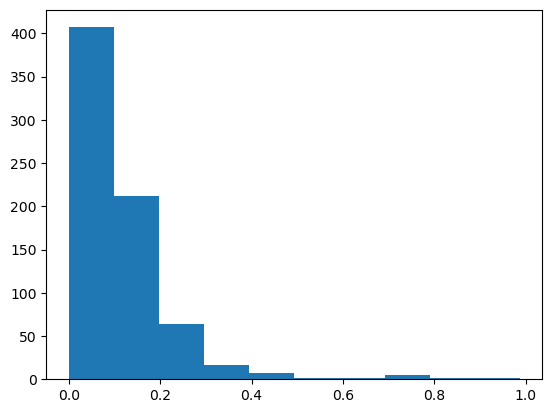

In [180]:
#These are the projects that have over 50% probability of being completed according to the model. 
#Let's join this with the original df.

predictions_df = pd.DataFrame(y_pred)
#y_pred[y_pred[0] > .3]
plt.hist(predictions_df,bins=10)
plt.show()

In [181]:
# calculate the p-values using statsmodels
logit_model = sm.Logit(y_test,X_test).fit()

#result=logit_model.fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.269814
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Status   No. Observations:                  718
Model:                          Logit   Df Residuals:                      713
Method:                           MLE   Df Model:                            4
Date:                Sun, 16 Apr 2023   Pseudo R-squ.:                  0.1300
Time:                        14:00:37   Log-Likelihood:                -193.73
converged:                       True   LL-Null:                       -222.68
Covariance Type:            nonrobust   LLR p-value:                 7.972e-12
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.6457      0.178    -14.869      0.000      -2.994      -2.297
x1            -1.1237      0.295     -3.806      0.000      -1.702      -0.545
x2             0.7778      0.134      5.792      0.000       0.515       1.041
x3            -0.3708      0.178     -2.082      0.037      -0.720      -0.022
x4             0.0677      0.154      0.439      0.660      -0.234       0.369
==============================================================================
"""

This combination of predictors doesn't help the model much either

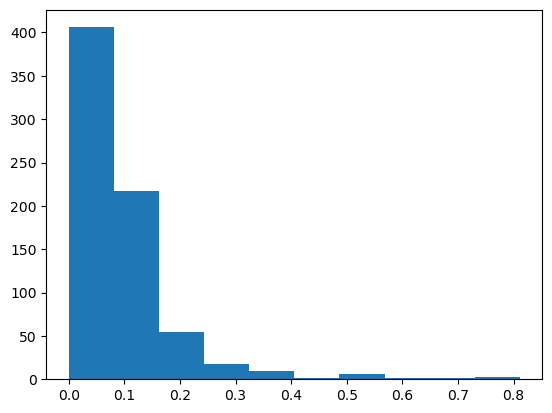

In [182]:
probabilities = logit_model.predict(X_test)

plt.hist(probabilities,bins=10)
plt.show()

## LogReg Attempt 5 with just statsmodels split, fit methods

In [249]:
X = inactive4.drop(columns="Status").astype('float64')
y = pd.get_dummies(inactive4["Status"]).drop(columns='WITHDRAWN').rename(columns={'COMPLETED':'Status'}).astype('float64')

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [251]:
X_train

,Capacity (MW),Project Length,storage,renewable
5250,14.000,2556.0,0.0,1.0
5241,450.000,1676.0,0.0,0.0
4799,20.000,2239.0,0.0,1.0
5324,92.600,1249.0,0.0,0.0
5108,600.000,3572.0,0.0,0.0
...,...,...,...,...
5866,50.000,2954.0,1.0,0.0
6031,306.870,2069.0,0.0,1.0
5589,20.000,1006.0,0.0,1.0
6196,117.405,980.0,0.0,1.0


In [252]:
logit_model = sm.Logit(np.asarray(y_train), sm.add_constant(np.asarray(X_train))).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.305899
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1255
Model:                          Logit   Df Residuals:                     1250
Method:                           MLE   Df Model:                            4
Date:                Sun, 16 Apr 2023   Pseudo R-squ.:                  0.1568
Time:                        15:27:24   Log-Likelihood:                -383.90
converged:                       True   LL-Null:                       -455.28
Covariance Type:            nonrobust   LLR p-value:                 7.228e-30
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2488      0.243     -9.243      0.000      -2.726      -1.772
x1            -0.0039      0.001     -5.729      0.000      -0.005      -0.003
x2             0.0009      0.000      8.555      0.000       0.001       0.001
x3            -1.9435      0.338     -5.743      0.000      -2.607      -1.280
x4            -0.6145      0.208     -2.959      0.003      -1.021      -0.208
==============================================================================
"""

In [253]:
y_pred = logit_model.predict(sm.add_constant(X_test))

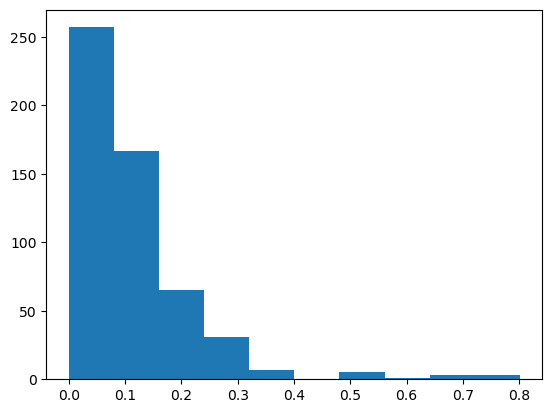

In [254]:
plt.hist(y_pred,bins=10)
plt.show()

## LogReg Attempt 6 (Training with inactive and testing with active)

In [234]:
X_train = inactive4.drop(columns="Status").astype('float64')
y_train = pd.get_dummies(inactive4["Status"]).drop(columns='WITHDRAWN').rename(columns={'COMPLETED':'Status'}).astype('float64')

In [235]:
logit_model = sm.Logit(np.asarray(y_train), sm.add_constant(np.asarray(X_train))).fit()
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.290734
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1794
Model:                          Logit   Df Residuals:                     1789
Method:                           MLE   Df Model:                            4
Date:                Sun, 16 Apr 2023   Pseudo R-squ.:                  0.1485
Time:                        14:54:24   Log-Likelihood:                -521.58
converged:                       True   LL-Null:                       -612.52
Covariance Type:            nonrobust   LLR p-value:                 2.930e-38
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.5182      0.218    -11.564      0.000      -2.945      -2.091
x1            -0.0038      0.001     -6.406      0.000      -0.005      -0.003
x2             0.0009    9.1e-05      9.935      0.000       0.001       0.001
x3            -1.7159      0.281     -6.111      0.000      -2.266      -1.166
x4            -0.4210      0.180     -2.334      0.020      -0.774      -0.068
==============================================================================
"""

In [236]:
X_test = active4.drop(columns="Status").astype('float64')

In [238]:
y_pred = logit_model.predict(sm.add_constant(X_test))

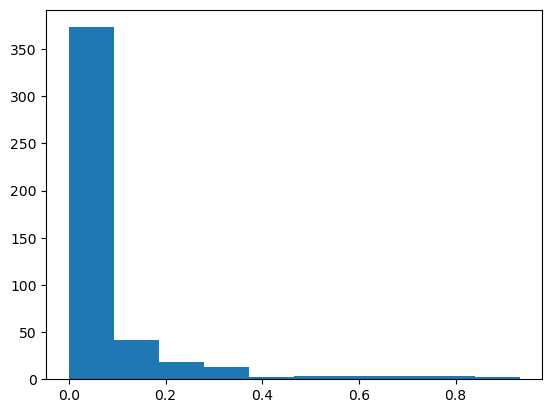

In [239]:
plt.hist(y_pred,bins=10)
plt.show()

In [241]:
active4

,Capacity (MW),Project Length,storage,renewable,Status
4253,38.00,2599,True,True,ACTIVE
4254,193.80,6795,False,True,ACTIVE
4255,73.27,6544,True,False,ACTIVE
4256,500.00,8594,True,False,ACTIVE
4257,150.00,6582,True,True,ACTIVE
...,...,...,...,...,...
4712,11.00,597,True,False,ACTIVE
4713,44.00,672,True,False,ACTIVE
4714,250.00,506,True,False,ACTIVE
4715,250.00,486,True,False,ACTIVE


In [243]:
active4["pred"] = y_pred

/var/folders/fb/lsg_5xw57mz9vhkmk6dvkfkw0000gn/T/ipykernel_1198/2956636599.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active4["preds"] = y_pred


In [248]:
active4[active4["preds"] > .7]

,Capacity (MW),Project Length,storage,renewable,Status,preds
4254,193.80,6795,False,True,ACTIVE,0.921480
4255,73.27,6544,True,False,ACTIVE,0.802454
4256,500.00,8594,True,False,ACTIVE,0.835251
4262,66.00,6296,True,False,ACTIVE,0.769466
4265,49.50,5906,False,False,ACTIVE,0.932874
4270,4.50,4216,False,True,ACTIVE,0.701605
4271,90.00,4841,False,True,ACTIVE,0.748956
4274,71.88,4515,False,True,ACTIVE,0.704251


Even for projects that are predicted to be 70% likely to be completed, there doesn't seem to be a clear pattern among the predictors. The bottom line is, many more projects get withdrawn than completed.